In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
import json
import logging
import multiprocessing
from functools import partial

# Data processing
import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid

# Networks
import networkx as nx

# Modules
sys.path.insert(0, '../scripts')

In [3]:
# Plotting
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

In [4]:
from evaluate import Evaluate
from gsd import GSD

# 0. Import experiment

In [5]:
home_dir = "../experiments/181123_k_noisy_clusters/"
data_param_file = os.path.join(home_dir, "data_specs.json")
model_param_file = os.path.join(home_dir, "model_specs.json")

In [6]:
e = Evaluate(home_dir, data_param_file, model_param_file)
e.data_specs

{'graph': '/nfs/latdata/iamjli/projects/GSD/data/interactomes/STRING_v10.5.experimental.costs_adj_g4.gpickle',
 'source_sampler_method': 'random_walk_fixed_size',
 'loading_sampler_method': 'k_noisy_clusters',
 'grid': {'n_sources': [10],
  'size': [100, 500, 1000],
  'n_samples': [20, 100, 500],
  'k_clusters': [5, 10, 20],
  'cluster_noise': [0, 0.1, 0.2],
  'noise': [0, 0.2, 0.4, 0.6, 0.8, 1.0],
  'rep': [1, 2, 3]}}

In [7]:
params_df = pd.DataFrame(list(e.data_paramlist))
params_df.head()

,cluster_noise,k_clusters,n_samples,n_sources,noise,rep,size
0,0.0,5,20,10,0.0,1,100
1,0.0,5,20,10,0.0,1,500
2,0.0,5,20,10,0.0,1,1000
3,0.0,5,20,10,0.0,2,100
4,0.0,5,20,10,0.0,2,500


In [8]:
len(params_df)

1458

# 1. What does input data look like

In [9]:
from sklearn.decomposition import PCA

### Choose parameter

In [10]:
params_df[(params_df["cluster_noise"] == 0.1) & (params_df["n_samples"] == 100) & (params_df["k_clusters"] == 10)].head()

,cluster_noise,k_clusters,n_samples,n_sources,noise,rep,size
702,0.1,10,100,10,0.0,1,100
703,0.1,10,100,10,0.0,1,500
704,0.1,10,100,10,0.0,1,1000
705,0.1,10,100,10,0.0,2,100
706,0.1,10,100,10,0.0,2,500


In [11]:
params = e.data_paramlist[702]
params

{'size': 100,
 'rep': 1,
 'noise': 0,
 'n_sources': 10,
 'n_samples': 100,
 'k_clusters': 10,
 'cluster_noise': 0.1}

### PCA transform

In [12]:
labels = (np.arange(params["n_samples"]) / params["n_samples"] * params["k_clusters"]).astype(int)
X = np.load(e._X_path(params))

In [13]:
pca = PCA(n_components=5)
X_transform = pca.fit_transform(X)

In [14]:
X_transform_df = pd.DataFrame(X_transform, columns=["Component "+str(x) for x in range(X_transform.shape[1])])
X_transform_df['label'] = labels
X_transform_df['label'] = X_transform_df['label'].astype('category')
X_transform_df.head()

,Component 0,Component 1,Component 2,Component 3,Component 4,label
0,6.091700,3.799510,-5.937575,-3.997656,-2.737054,0
1,15.453819,8.514990,-12.292003,6.602461,-1.118061,0
2,7.263939,5.177320,-7.668636,-2.457063,6.788334,0
3,6.849617,6.528338,-5.161278,-1.385880,2.933164,0
4,7.821754,4.603761,-10.076821,-4.813553,3.530587,0


### Plot

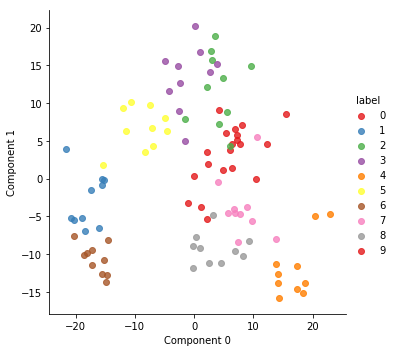

In [15]:
sns.lmplot(x="Component 0", y="Component 1", hue='label', data=X_transform_df, palette="Set1", fit_reg=False, height=5);

# 2. Evaluate performance

In [16]:
scores_df = e.get_scores_as_dataframe()

In [28]:
scores_df = scores_df.rename(columns={"F1rr": "Score"})

In [39]:
sns.set(font_scale = )

In [50]:
def plot_scores(scores, q): 
    
    filtered = scores_df.query(q)
    
    plt.figure(figsize=(12,8))
    palette = sns.color_palette("tab20c", 3) + sns.color_palette("tab20c", 7)[-3:]
    sns.lineplot(x='noise', y='Score', hue='model', data=filtered, palette=palette);
    
def plot_comparison(scores, qs, figsize=(20,6)): 
    
    filtered = [ scores_df.query(q) for q in qs ]
    
    palette = sns.color_palette("tab20c", 3) + sns.color_palette("tab20c", 7)[-3:]
    
    f, axes = plt.subplots(1,len(qs), figsize=figsize)
    
    for df,ax in zip(*[filtered, axes]): 
        sns.lineplot(x='noise', y='Score', hue='model', data=df, palette=palette, ax=ax);
        ax.set_ylim([0,1])
        ax.tick_params(labelsize=15)
        ax.set_xlabel("Noise", fontsize=20)
        ax.set_ylabel("Score", fontsize=20)

### GSD performs well when support size is large

Also, as noise increases, more strict parameter improves score. 

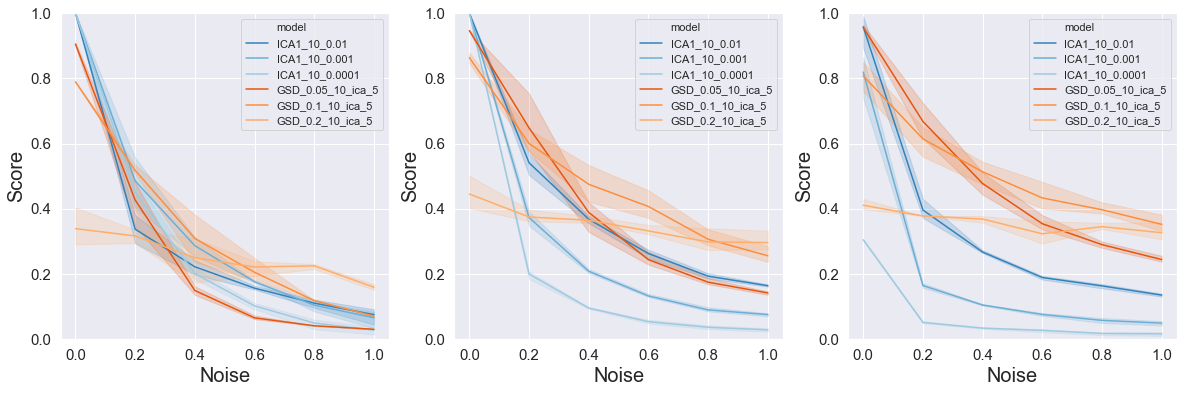

In [51]:
q1 = 'n_sources == 10 & size == 100 & cluster_noise == 0 & k_clusters == 10 & n_samples == 20'
q2 = 'n_sources == 10 & size == 500 & cluster_noise == 0 & k_clusters == 10 & n_samples == 20'
q3 = 'n_sources == 10 & size == 1000 & cluster_noise == 0 & k_clusters == 10 & n_samples == 20'

plot_comparison(scores_df, [q1, q2, q3], figsize=(20,6))

### GSD performs relatively well in low-data environments

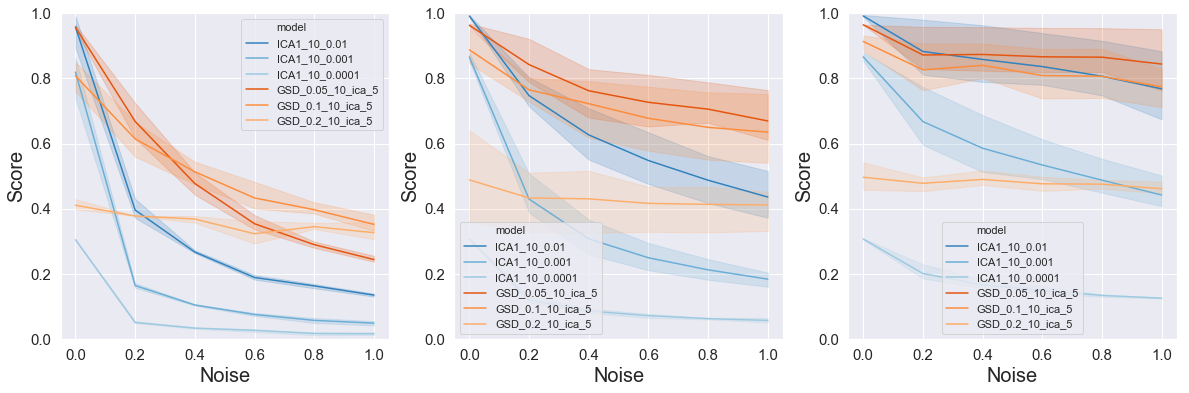

In [52]:
q1 = 'n_sources == 10 & size == 1000 & cluster_noise == 0 & k_clusters == 10 & n_samples == 20'
q2 = 'n_sources == 10 & size == 1000 & cluster_noise == 0 & k_clusters == 10 & n_samples == 100'
q3 = 'n_sources == 10 & size == 1000 & cluster_noise == 0 & k_clusters == 10 & n_samples == 500'

plot_comparison(scores_df, [q1, q2, q3], figsize=(20,6))

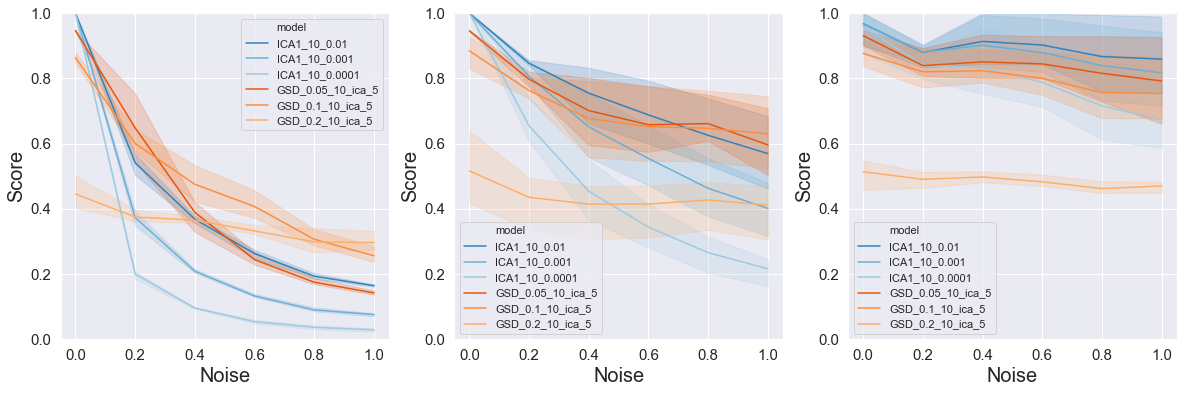

In [53]:
q1 = 'n_sources == 10 & size == 500 & cluster_noise == 0 & k_clusters == 10 & n_samples == 20'
q2 = 'n_sources == 10 & size == 500 & cluster_noise == 0 & k_clusters == 10 & n_samples == 100'
q3 = 'n_sources == 10 & size == 500 & cluster_noise == 0 & k_clusters == 10 & n_samples == 500'

plot_comparison(scores_df, [q1, q2, q3], figsize=(20,6))

### Number of clusters

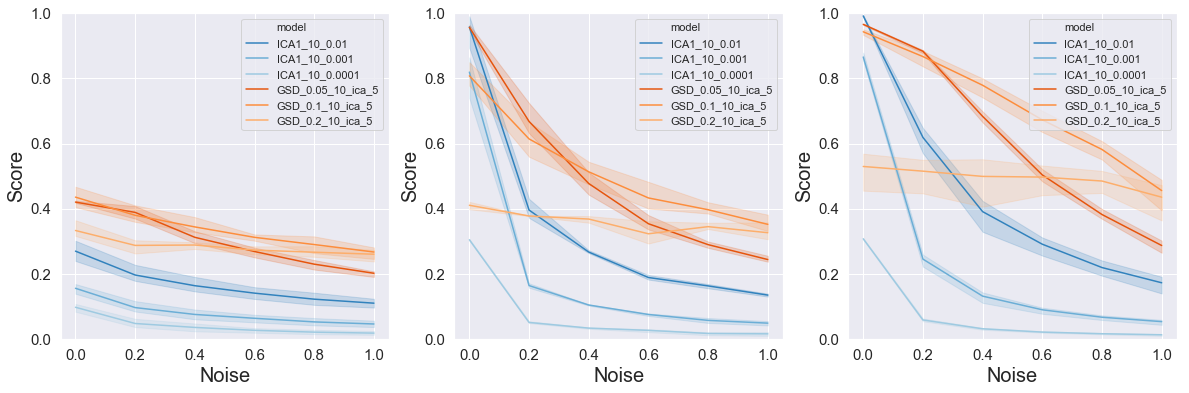

In [58]:
q1 = 'n_sources == 10 & size == 1000 & cluster_noise == 0 & k_clusters == 5 & n_samples == 20'
q2 = 'n_sources == 10 & size == 1000 & cluster_noise == 0 & k_clusters == 10 & n_samples == 20'
q3 = 'n_sources == 10 & size == 1000 & cluster_noise == 0 & k_clusters == 20 & n_samples == 20'

plot_comparison(scores_df, [q1, q2, q3])

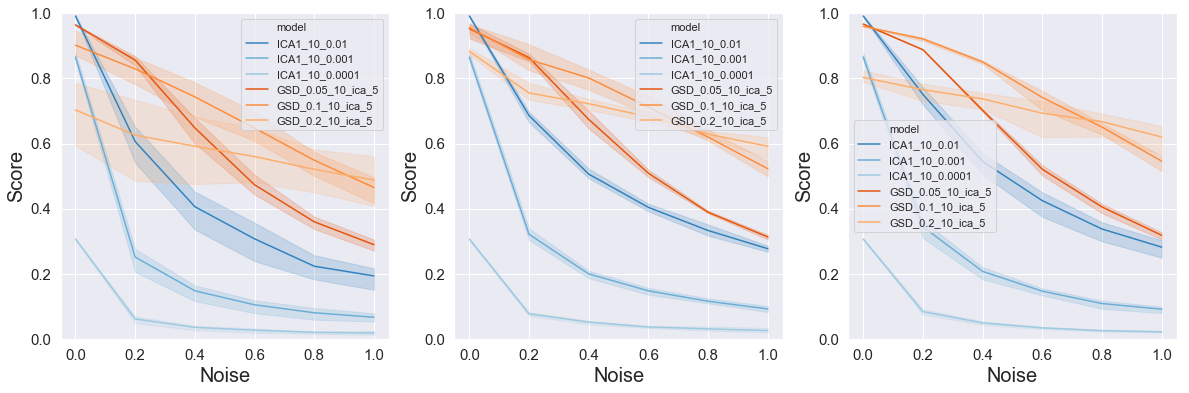

In [59]:
q1 = 'n_sources == 10 & size == 1000 & cluster_noise == 0.2 & k_clusters == 5 & n_samples == 20'
q2 = 'n_sources == 10 & size == 1000 & cluster_noise == 0.2 & k_clusters == 10 & n_samples == 20'
q3 = 'n_sources == 10 & size == 1000 & cluster_noise == 0.2 & k_clusters == 20 & n_samples == 20'

plot_comparison(scores_df, [q1, q2, q3])

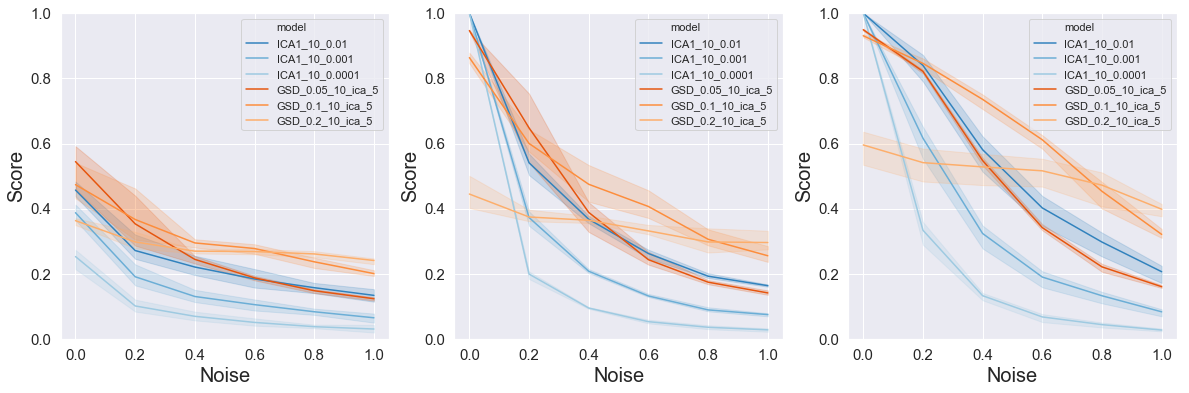

In [54]:
q1 = 'n_sources == 10 & size == 500 & cluster_noise == 0 & k_clusters == 5 & n_samples == 20'
q2 = 'n_sources == 10 & size == 500 & cluster_noise == 0 & k_clusters == 10 & n_samples == 20'
q3 = 'n_sources == 10 & size == 500 & cluster_noise == 0 & k_clusters == 20 & n_samples == 20'

plot_comparison(scores_df, [q1, q2, q3])

### Cluster noise

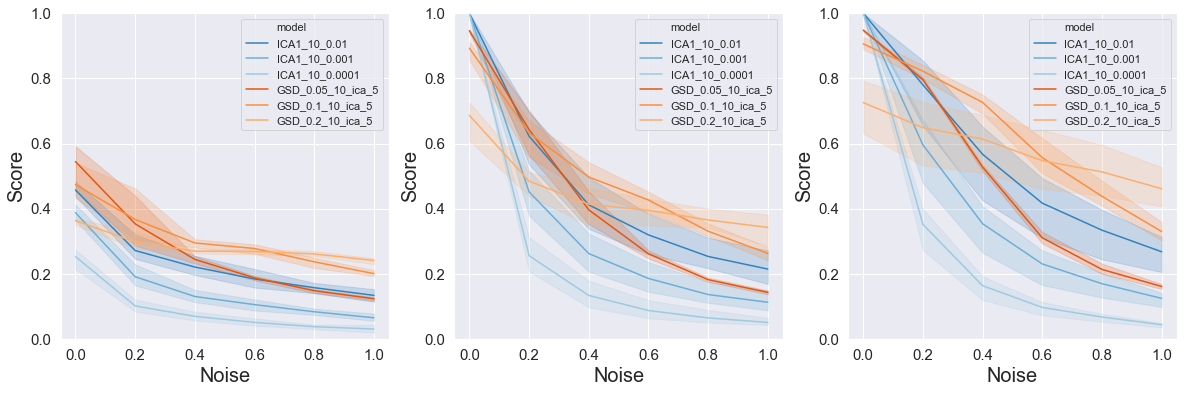

In [55]:
q1 = 'n_sources == 10 & size == 500 & cluster_noise == 0 & k_clusters == 5 & n_samples == 20'
q2 = 'n_sources == 10 & size == 500 & cluster_noise == 0.1 & k_clusters == 5 & n_samples == 20'
q3 = 'n_sources == 10 & size == 500 & cluster_noise == 0.2 & k_clusters == 5 & n_samples == 20'

plot_comparison(scores_df, [q1, q2, q3])

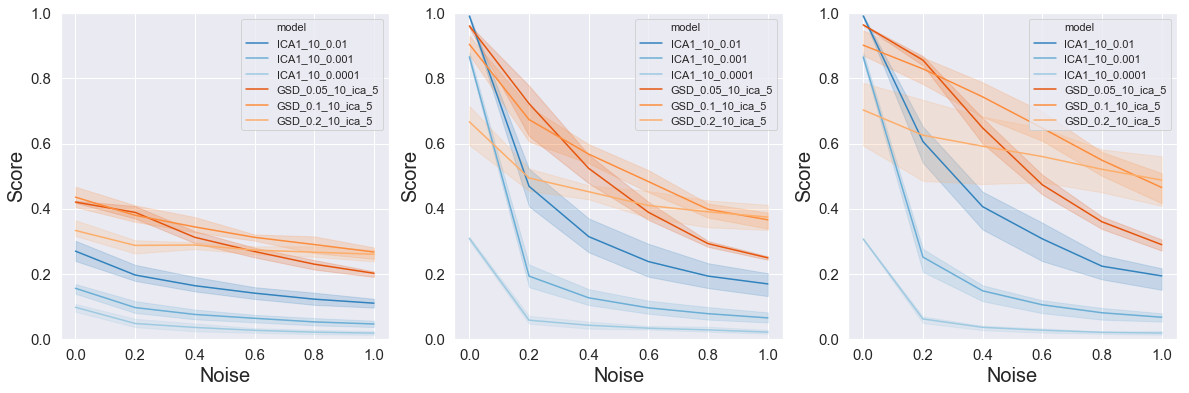

In [56]:
q1 = 'n_sources == 10 & size == 1000 & cluster_noise == 0 & k_clusters == 5 & n_samples == 20'
q2 = 'n_sources == 10 & size == 1000 & cluster_noise == 0.1 & k_clusters == 5 & n_samples == 20'
q3 = 'n_sources == 10 & size == 1000 & cluster_noise == 0.2 & k_clusters == 5 & n_samples == 20'

plot_comparison(scores_df, [q1, q2, q3])

# MISC

Aggregate data

In [120]:
summary_df = scores_df.groupby(by=["model", "n_sources", "size", "k_clusters", "cluster_noise", "n_samples", "noise"]) \
                      .agg([np.mean, np.std]).drop(columns=['rep'])
summary_df.head()

F1rr  \
                                                                               mean   
model             n_sources size k_clusters cluster_noise n_samples noise             
GSD_0.05_10_ica_5 10        100  5          0.0           20        0.0    0.489692   
                                                                    0.2    0.261534   
                                                                    0.4    0.118637   
                                                                    0.6    0.061144   
                                                                    0.8    0.040866   

                                                                                     \
                                                                                std   
model             n_sources size k_clusters cluster_noise n_samples noise             
GSD_0.05_10_ica_5 10        100  5          0.0           20        0.0    0.104910   
                                                                    0.2    0.069738   
                                                                    0.4    0.004099   
                                                                    0.6    0.003727   
                                                                    0.8    0.001024   

                                                                           recovery  \
                                                                               mean   
model             n_sources size k_clusters cluster_noise n_samples noise             
GSD_0.05_10_ica_5 10        100  5          0.0           20        0.0    0.541629   
                                                                    0.2    0.313694   
                                                                    0.4    0.136925   
                                                                    0.6    0.070441   
                                                                    0.8    0.044672   

                                                                                     \
                                                                                std   
model             n_sources size k_clusters cluster_noise n_samples noise             
GSD_0.05_10_ica_5 10        100  5          0.0           20        0.0    0.096970   
                                                                    0.2    0.044366   
                                                                    0.4    0.008966   
                                                                    0.6    0.007111   
                                                                    0.8    0.001473   

                                                                          relevance  \
                                                                               mean   
model             n_sources size k_clusters cluster_noise n_samples noise             
GSD_0.05_10_ica_5 10        100  5          0.0           20        0.0    0.447384   
                                                                    0.2    0.227682   
                                                                    0.4    0.105237   
                                                                    0.6    0.054097   
                                                                    0.8    0.037663   

                                                                                     
                                                                                std  
model             n_sources size k_clusters cluster_noise n_samples noise            
GSD_0.05_10_ica_5 10        100  5          0.0           20        0.0    0.109003  
                                                                    0.2    0.084101  
                                                                    0.4    0.009108  
                                                                    0.6    0.0